In [154]:
from pathlib import Path
import pandas as pd
import os
import numpy as np

### dirs and dataset

In [39]:
project_dir = os.path.abspath(os.curdir)
project_dir = project_dir.split('recatizer/')[0] + 'recatizer/'
 

'/home/art/PycharmProjects/recatizer/'

In [112]:
raw_data_dir = project_dir + 'data/raw/' # <- The original, immutable data dump.
intermediate_data_output_dir = project_dir + \
        'data/interim/cat_individuals_dataset/'# <- Intermediate data that has been transformed.
processed_data_output_dir = project_dir + \
        'data/processed/'#  <- The final, canonical data sets for modeling.   

In [47]:
dataset = pd.read_csv(raw_data_dir + 'images_database.csv', index_col=0)
dataset.head()

,cat_id,img,path
0,0035,0035_013.JPG,0035/0035_013.JPG
1,0035,0035_009.JPG,0035/0035_009.JPG
2,0035,0035_000.JPG,0035/0035_000.JPG
3,0035,0035_005.JPG,0035/0035_005.JPG
4,0035,0035_003.JPG,0035/0035_003.JPG


#### amount files about every cats

In [91]:
def calc_every_cat_files_num(dataset):
    cat_ids = dataset.cat_id.unique()
    # every_cat_imgs_num = 
    every_cat_imgs_num =[]
    for cat_id in cat_ids:
        every_cat_imgs_num.append(
            {'id': cat_id, 
             'amount_files': len(dataset.cat_id[dataset.cat_id == cat_id])}   
        )
    return pd.DataFrame(every_cat_imgs_num)


every_cat_imgs_num = calc_every_cat_files_num(dataset)

In [96]:
every_cat_imgs_num.sort_values(by=['amount_files'], ascending=False).head(20)

,id,amount_files
271,0455_357,357
270,0455,357
89,0454,229
3,0190,144
362,0160,130
441,0375,110
42,0191,101
5,0212,98
490,0474,98
305,0446,95


array([[<AxesSubplot:title={'center':'amount_files'}>]], dtype=object)

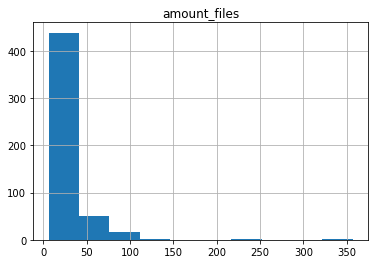

In [94]:
every_cat_imgs_num.hist(column='amount_files')

In [63]:
## file formats

file_formats = set()
for file in dataset.img:
    cur_format = file.split('.')[-1].lower()
    file_formats.add(cur_format)
print('file formats:', file_formats)

file formats: {'jpg', 'db', 'txt', 'heic', 'jpeg', 'mp4', 'png', 'mov'}


### divide into three datasets (imgs, videos, others)

In [70]:
## add column with format label
format_label = []

for row_id in dataset.index:
    dataset.loc[row_id, 'format'] = dataset.loc[row_id, 'img'].split('.')[-1].lower()

In [82]:
def return_files_in_format(df, formats):
    return df.loc[lambda df: df.format.isin(formats)]


video_formats = set(['mp4', 'mov'])
image_formats = set(['jpg', 'heic', 'jpeg', 'png'])
other_formats = file_formats - video_formats - image_formats

images_database = return_files_in_format(dataset, image_formats)
movies_database = return_files_in_format(dataset, video_formats)   
other_database = return_files_in_format(dataset, other_formats)       

In [115]:
def save_df_to_path(df, path, name):
    """save dataset in path"""
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    
    df.to_csv(path + name)
    return 'ok'

#### Others dataset

In [101]:
calc_every_cat_files_num(other_database)

,id,amount_files
0,0077,1
1,0432,1
2,0131,1
3,0128,1
4,0083,1


In [116]:
save_df_to_path(other_database, intermediate_data_output_dir, 'other_database.csv')

'ok'

#### Movies dataset

In [97]:
calc_every_cat_files_num(movies_database)

,id,amount_files
0,0454,28
1,0200,1
2,0455,10
3,0455_357,10


In [117]:
save_df_to_path(movies_database, intermediate_data_output_dir, 'movies_database.csv')
        

'ok'

#### Images dataset

In [128]:
imgs_num = calc_every_cat_files_num(
    images_database).sort_values(by=['amount_files'], ascending=False)

In [131]:
imgs_num.amount_files.describe()

count    510.000000
mean      27.107843
std       28.638354
min        6.000000
25%       14.000000
50%       20.000000
75%       30.000000
max      347.000000
Name: amount_files, dtype: float64

In [132]:
imgs_num.amount_files.median()

20.0

In [141]:
imgs_num

,id,amount_files
271,0455_357,347
270,0455,347
89,0454,201
3,0190,144
362,0160,130
...,...,...
129,0111,6
462,0335,6
378,0039,6
442,0038,6


In [150]:
 imgs_num.loc[imgs_num.id==cat_id, 'amount_files'].values

array([347])

In [142]:
imgs_num.id[imgs_num.id == cat_id]

271    0455_357
Name: id, dtype: object

In [197]:
max_img_amount = int(imgs_num.amount_files.median())

extra_cats_imgs = pd.DataFrame()
processed_cats_imgs = pd.DataFrame()

for cat_id in imgs_num.id:
   
    extra_imgs = pd.DataFrame()
    cat_imgs = images_database.loc[dataset.cat_id == cat_id, :]
    if  imgs_num.loc[imgs_num.id==cat_id, 'amount_files'].values > max_img_amount:
            _cat_imgs = cat_imgs.sample(n=max_img_amount, random_state=1) 
            extra_imgs = cat_imgs.drop(_cat_imgs.index)
       
            cat_imgs = _cat_imgs
            extra_cats_imgs = extra_cats_imgs.append(extra_imgs, ignore_index=True)
            
            
    processed_cats_imgs = processed_cats_imgs.append(cat_imgs, ignore_index=True)
        
        

        
    
    
        

array([[<AxesSubplot:title={'center':'amount_files'}>]], dtype=object)

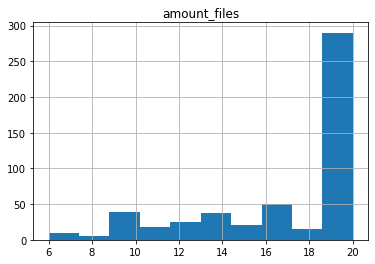

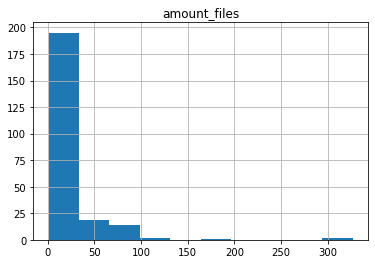

In [196]:
calc_every_cat_files_num(processed_cats_imgs).hist()
calc_every_cat_files_num(extra_cats_imgs).hist()

In [199]:
save_df_to_path(processed_cats_imgs, 
                processed_data_output_dir, 
                'cat_individual_database.csv')
save_df_to_path(extra_cats_imgs, 
                processed_data_output_dir, 
                'cat_individual_database_extra_images.csv')

'ok'